In [2]:
!python -m pip install tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Import libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import warnings
warnings.filterwarnings('ignore')


# Load the Dataset

In [34]:
df = pd.read_csv('combined_cleaned_original_datasets.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

# Rename columns for clarity and consistency
df.rename(columns={'label': 'LABEL', 'text': 'TEXT', 'label_num': 'label_encoded'}, inplace=True)

# Show first few rows
print(df.head())

# Basic dataset info
print("Dataset Information:")
print(f"Total messages: {len(df)}")
print(f"\nClass distribution:")
print(df['LABEL'].value_counts())
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nDuplicates: {df.duplicated().sum()}")

Dataset shape: (5944, 3)

First few rows:
   LABEL                                               TEXT  label_encoded
0    ham  Go until jurong point, crazy.. Available only ...              0
1    ham                      Ok lar... Joking wif u oni...              0
2  smish  Free entry in 2 a wkly comp to win FA Cup fina...              1
3    ham  U dun say so early hor... U c already then say...              0
4    ham  Nah I don't think he goes to usf, he lives aro...              0
Dataset Information:
Total messages: 5944

Class distribution:
LABEL
ham      5025
smish     919
Name: count, dtype: int64

Missing values:
LABEL            0
TEXT             0
label_encoded    0
dtype: int64

Duplicates: 0


# Text Sanitization

In [35]:
# Replace URLs, emails, phone numbers with tokens.
# This helps the model focus on patterns rather than specific values.

def sanitize_text(text):
    # Replace URLs, emails, phone numbers with tokens
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Replace URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, 'URLTOKEN', text)
    text = re.sub(r'www\.[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', 'URLTOKEN', text)
    
    # Replace emails
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    text = re.sub(email_pattern, 'EMAILTOKEN', text)
    
    # Replace phone numbers
    phone_patterns = [
        r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b',
        r'\+?\d{1,3}[-.\s]?\(?\d{2,4}\)?[-.\s]?\d{3,4}[-.\s]?\d{3,4}',
        r'\b\d{7,11}\b',
    ]
    for pattern in phone_patterns:
        text = re.sub(pattern, 'PHONETOKEN', text)
    
    # Replace currency symbols
    text = re.sub(r'[£$€¥₹]', 'CURRENCYTOKEN', text)
    
    # Replace numbers (but keep our tokens safe)
    text = re.sub(r'\b\d+\.?\d*\b', 'NUMBERTOKEN', text)
    
    return text

# Apply sanitization
df['sanitized_text'] = df['TEXT'].apply(sanitize_text)

print("Examples of sanitization:")
for i in range(3):
    print(f"\nOriginal: {df['TEXT'].iloc[i][:80]}...")
    print(f"Sanitized: {df['sanitized_text'].iloc[i][:80]}...")


Examples of sanitization:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet...
Sanitized: Go until jurong point, crazy.. Available only in bugis n great world la e buffet...

Original: Ok lar... Joking wif u oni......
Sanitized: Ok lar... Joking wif u oni......

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
Sanitized: Free entry in NUMBERTOKEN a wkly comp to win FA Cup final tkts 21st May NUMBERTO...


# Text Cleaning

In [36]:
# For deep learning:
# - Convert to lowercase
# - Remove extra punctuation (but keep basic structure)
# - Keep ALL words (no stop-word removal)

# %%
def clean_text(text):
    # Basic cleaning while preserving word structure
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra punctuation but keep basic structure
    # Keep periods, question marks for sentence structure
    text = re.sub(r'[^\w\s?.!]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

df['cleaned_text'] = df['sanitized_text'].apply(clean_text)

print("\nExamples:")
for i in range(3):
    print(f"\nOriginal: {df['TEXT'].iloc[i]}")
    print(f"\nCleaned: {df['cleaned_text'].iloc[i]}")



Examples:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Cleaned: go until jurong point crazy.. available only in bugis n great world la e buffet... cine there got amore wat...

Original: Ok lar... Joking wif u oni...

Cleaned: ok lar... joking wif u oni...

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Cleaned: free entry in numbertoken a wkly comp to win fa cup final tkts 21st may numbertoken. text fa to numbertoken to receive entry question std txt rate t c s apply phonetokenover18 s


# Additional Features

In [37]:
# These can be used as extra inputs to the model alongside text sequences
# Create additional features
df['msg_length'] = df['TEXT'].apply(len)
df['word_count'] = df['TEXT'].apply(lambda x: len(str(x).split()))

# Count special tokens
df['url_count'] = df['sanitized_text'].str.lower().str.count('urltoken')
df['email_count'] = df['sanitized_text'].str.lower().str.count('emailtoken')
df['phone_count'] = df['sanitized_text'].str.lower().str.count('phonetoken')
df['number_count'] = df['sanitized_text'].str.lower().str.count('numbertoken')
df['currency_count'] = df['sanitized_text'].str.lower().str.count('currencytoken')

# Capital letter ratio
df['capital_ratio'] = df['TEXT'].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
)

# Special character count
df['special_char_count'] = df['TEXT'].apply(
    lambda x: sum(1 for c in str(x) if c in string.punctuation)
)

print(f"Total columns: {df.shape[1]}")

additional_features = ['msg_length', 'word_count', 'url_count', 'email_count', 
                      'phone_count', 'number_count', 'currency_count', 
                      'capital_ratio', 'special_char_count']

print("\nFeature statistics:")
df[additional_features].describe()


Total columns: 14

Feature statistics:


,msg_length,word_count,url_count,email_count,phone_count,number_count,currency_count,capital_ratio,special_char_count
count,5944.000000,5944.000000,5944.000000,5944.000000,5944.000000,5944.000000,5944.000000,5944.000000,5944.000000
mean,81.859690,15.722914,0.022712,0.002692,0.104980,0.428499,0.060061,0.067333,4.184388
std,59.145911,11.110679,0.148996,0.051817,0.332363,1.072942,0.288182,0.113521,4.440038
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,2.000000
50%,64.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037736,3.000000
75%,124.250000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061224,6.000000
max,910.000000,171.000000,1.000000,1.000000,2.000000,13.000000,3.000000,1.000000,133.000000


In [39]:
# Drop the original categorical label column as we have the numerical one
df.rename(columns={'label_encoded': 'label'}, inplace=True)
y = df['label'].astype(int).values

print(y[:10])
print(y.dtype)
print(sum(y == 0), sum(y == 1))

[0 0 1 0 0 1 0 0 1 1]
int64
5025 919


# Text Tokenization (Keras Tokenizer)

In [40]:
# This converts words to numbers. Each unique word gets a unique number.

# Set parameters
MAX_WORDS = 10000  # Maximum number of words to keep (most frequent)
MAX_LEN = 100      # Maximum length of sequences (will pad/truncate to this)

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])

# Get vocabulary info
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding token

print(f"Total unique words: {len(word_index)}")
print(f"Vocabulary size (limited to top {MAX_WORDS}): {min(vocab_size, MAX_WORDS)}")

# Show some examples
print("\nWord to index mapping (first 20 words):")
for i, (word, idx) in enumerate(list(word_index.items())[:20]):
    print(f"  '{word}': {idx}")

Total unique words: 8526
Vocabulary size (limited to top 10000): 8527

Word to index mapping (first 20 words):
  '<OOV>': 1
  'i': 2
  'numbertoken': 3
  'to': 4
  'you': 5
  'a': 6
  'the': 7
  'u': 8
  'and': 9
  'is': 10
  'in': 11
  'your': 12
  'me': 13
  'my': 14
  'for': 15
  'it': 16
  'call': 17
  'of': 18
  'have': 19
  'that': 20


# Convert Text to Sequences

Converted 5944 texts to sequences

Example conversions:

Text: go until jurong point crazy.. available only in bugis n grea...
Sequence: [55, 441, 4254, 813, 734, 712, 70, 11, 1345, 108, 135, 369, 1346, 166, 2892]...

Text: ok lar... joking wif u oni......
Sequence: [50, 337, 1348, 486, 8, 1918]...

Text: free entry in numbertoken a wkly comp to win fa cup final tk...
Sequence: [51, 528, 11, 3, 6, 956, 901, 4, 221, 2893, 1214, 502, 2276, 2894, 252]...

Sequence length statistics:
  Min: 0
  Max: 190
  Mean: 16.32
  Median: 13.00


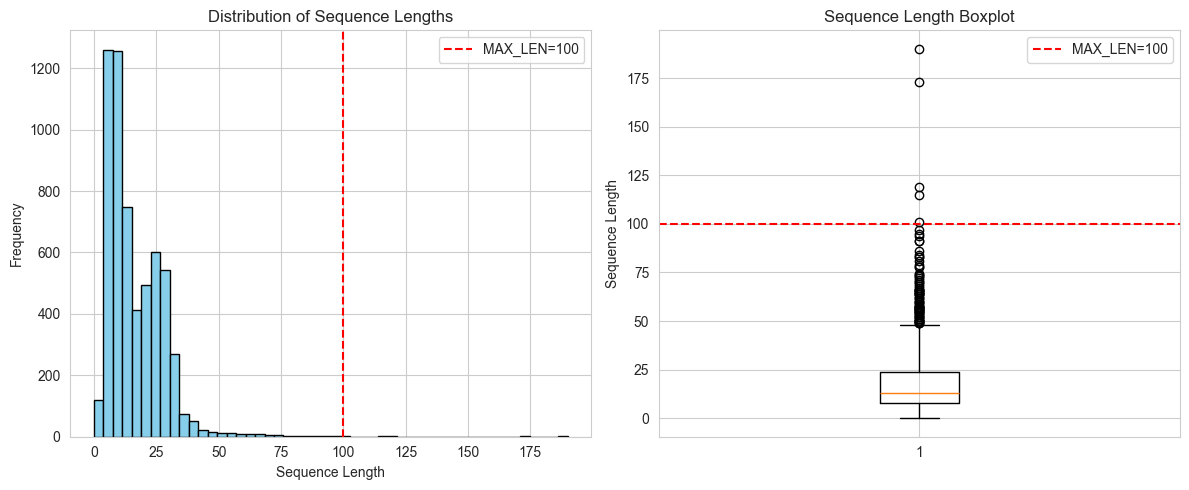

In [41]:
# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

print(f"Converted {len(sequences)} texts to sequences")

# Show examples
print("\nExample conversions:")
for i in range(3):
    print(f"\nText: {df['cleaned_text'].iloc[i][:60]}...")
    print(f"Sequence: {sequences[i][:15]}...")  # Show first 15 numbers

# Check sequence lengths
sequence_lengths = [len(seq) for seq in sequences]
print(f"\nSequence length statistics:")
print(f"  Min: {min(sequence_lengths)}")
print(f"  Max: {max(sequence_lengths)}")
print(f"  Mean: {np.mean(sequence_lengths):.2f}")
print(f"  Median: {np.median(sequence_lengths):.2f}")

# Plot sequence length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.axvline(MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN={MAX_LEN}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(sequence_lengths)
plt.ylabel('Sequence Length')
plt.title('Sequence Length Boxplot')
plt.axhline(MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN={MAX_LEN}')
plt.legend()

plt.tight_layout()
plt.show()

# Padding Sequences

In [42]:
# All sequences must have the same length for deep learning models.
# - Short sequences: pad with zeros
# - Long sequences: truncate

# Pad sequences to same length
X_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Padded sequences shape: {X_sequences.shape}")
print(f"All sequences now have length: {MAX_LEN}")

# Show some examples
print("\nPadding examples:")
for i in range(3):
    print(f"\nOriginal length: {len(sequences[i])}")
    print(f"Original sequence: {sequences[i][:10]}...")
    print(f"Padded sequence: {X_sequences[i][:10]}...{X_sequences[i][-5:]}")

# Check how many sequences were truncated
truncated = sum(1 for seq in sequences if len(seq) > MAX_LEN)
print(f"\nSequences truncated: {truncated} out of {len(sequences)} ({truncated/len(sequences)*100:.2f}%)")

Padded sequences shape: (5944, 100)
All sequences now have length: 100

Padding examples:

Original length: 20
Original sequence: [55, 441, 4254, 813, 734, 712, 70, 11, 1345, 108]...
Padded sequence: [  55  441 4254  813  734  712   70   11 1345  108]...[0 0 0 0 0]

Original length: 6
Original sequence: [50, 337, 1348, 486, 8, 1918]...
Padded sequence: [  50  337 1348  486    8 1918    0    0    0    0]...[0 0 0 0 0]

Original length: 33
Original sequence: [51, 528, 11, 3, 6, 956, 901, 4, 221, 2893]...
Padded sequence: [  51  528   11    3    6  956  901    4  221 2893]...[0 0 0 0 0]

Sequences truncated: 5 out of 5944 (0.08%)


# Prepare Additional Features

In [43]:
# Get additional features as numpy array
X_features = df[additional_features].values

print(f"Additional features shape: {X_features.shape}")
print(f"Features: {additional_features}")

# Normalize features (important for neural networks)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

print("\nFeatures normalized using StandardScaler")
print("Before normalization (first sample):")
print(X_features[0])
print("\nAfter normalization (first sample):")
print(X_features_scaled[0])


Additional features shape: (5944, 9)
Features: ['msg_length', 'word_count', 'url_count', 'email_count', 'phone_count', 'number_count', 'currency_count', 'capital_ratio', 'special_char_count']

Features normalized using StandardScaler
Before normalization (first sample):
[1.1100000e+02 2.0000000e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.7027027e-02 9.0000000e+00]

After normalization (first sample):
[ 0.49272656  0.38498511 -0.15244606 -0.05195243 -0.31588592 -0.39940208
 -0.20842968 -0.3550837   1.08467943]


#  Get Labels

In [44]:
y = df['label'].values

print(f"Labels shape: {y.shape}")
print(f"Label distribution:")
print(f"  Ham (0): {sum(y == 0)}")
print(f"  Smish (1): {sum(y == 1)}")

Labels shape: (5944,)
Label distribution:
  Ham (0): 5025
  Smish (1): 919


# Train-Test Split

In [45]:
# Split everything into train and test sets
X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_sequences, 
    X_features_scaled, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining set:")
print(f"  Sequences shape: {X_seq_train.shape}")
print(f"  Features shape: {X_feat_train.shape}")
print(f"  Labels shape: {y_train.shape}")
print(f"  Samples: {len(y_train)} ({len(y_train)/len(y)*100:.1f}%)")

print(f"\nTest set:")
print(f"  Sequences shape: {X_seq_test.shape}")
print(f"  Features shape: {X_feat_test.shape}")
print(f"  Labels shape: {y_test.shape}")
print(f"  Samples: {len(y_test)} ({len(y_test)/len(y)*100:.1f}%)")

print(f"\nClass distribution in training set:")
print(f"  Ham (0): {sum(y_train == 0)}")
print(f"  Smish (1): {sum(y_train == 1)}")

print(f"\nClass distribution in test set:")
print(f"  Ham (0): {sum(y_test == 0)}")
print(f"  Smish (1): {sum(y_test == 1)}")


Training set:
  Sequences shape: (4755, 100)
  Features shape: (4755, 9)
  Labels shape: (4755,)
  Samples: 4755 (80.0%)

Test set:
  Sequences shape: (1189, 100)
  Features shape: (1189, 9)
  Labels shape: (1189,)
  Samples: 1189 (20.0%)

Class distribution in training set:
  Ham (0): 4020
  Smish (1): 735

Class distribution in test set:
  Ham (0): 1005
  Smish (1): 184


# Exploratory Data Analysis

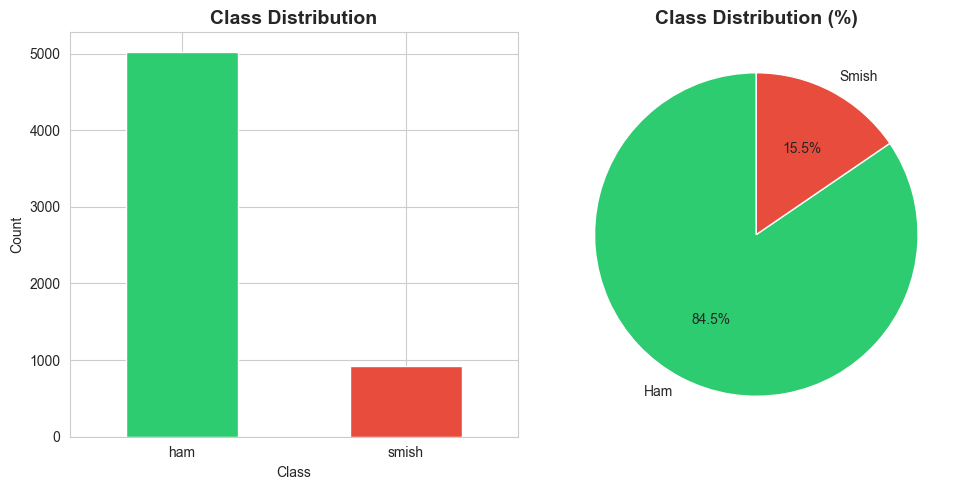

In [46]:
# Set plot style
sns.set_style('whitegrid')

# Class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['LABEL'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
labels = ['Ham', 'Smish']
sizes = df['LABEL'].value_counts()
colors = ['#2ecc71', '#e74c3c']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Message statistics by class:
      msg_length                                                           \
           count        mean        std   min    25%    50%    75%    max   
LABEL                                                                       
ham       5025.0   71.526169  57.066144   2.0   34.0   53.0   93.0  910.0   
smish      919.0  138.362350  32.314838  13.0  128.0  146.0  156.0  383.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
LABEL                                                                 
ham       5025.0  14.324776  11.253237  1.0   7.0  11.0  19.0  171.0  
smish      919.0  23.367791   6.076643  2.0  21.0  24.0  27.0   68.0  


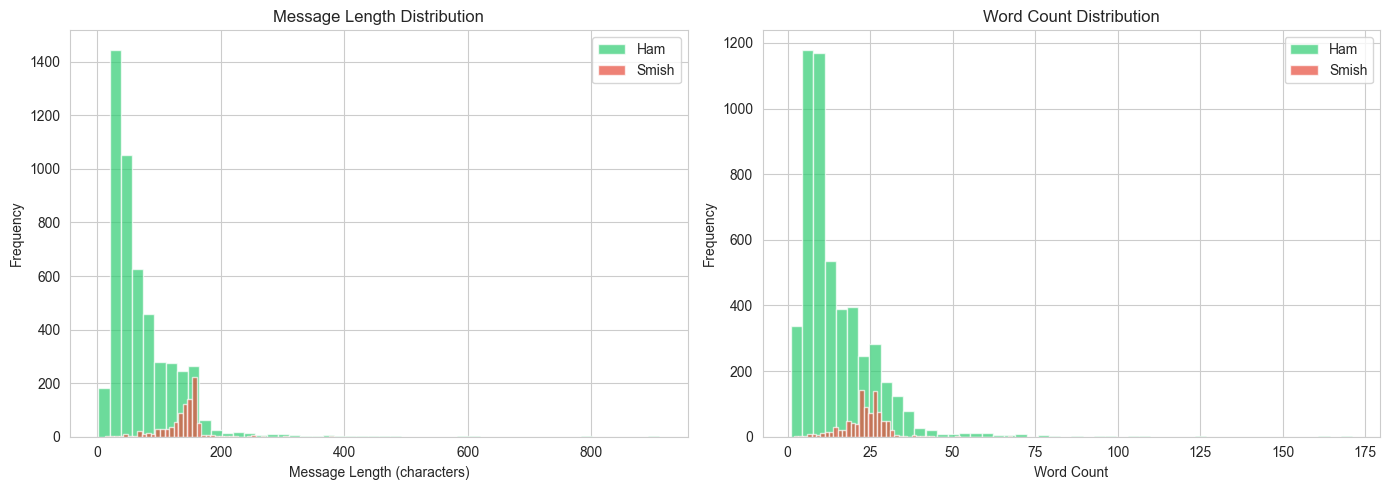

In [47]:
# Message length by class
print("Message statistics by class:")
print(df.groupby('LABEL')[['msg_length', 'word_count']].describe())

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df[df['LABEL'] == 'ham']['msg_length'].hist(bins=50, alpha=0.7, label='Ham', color='#2ecc71')
df[df['LABEL'] == 'smish']['msg_length'].hist(bins=50, alpha=0.7, label='Smish', color='#e74c3c')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.title('Message Length Distribution')
plt.legend()

plt.subplot(1, 2, 2)
df[df['LABEL'] == 'ham']['word_count'].hist(bins=50, alpha=0.7, label='Ham', color='#2ecc71')
df[df['LABEL'] == 'smish']['word_count'].hist(bins=50, alpha=0.7, label='Smish', color='#e74c3c')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.legend()

plt.tight_layout()
plt.show()


Average special token counts by class:
       url_count  email_count  phone_count  number_count  currency_count
LABEL                                                                   
ham     0.000597     0.000199     0.000995      0.193632        0.004975
smish   0.143634     0.016322     0.673558      1.712731        0.361262


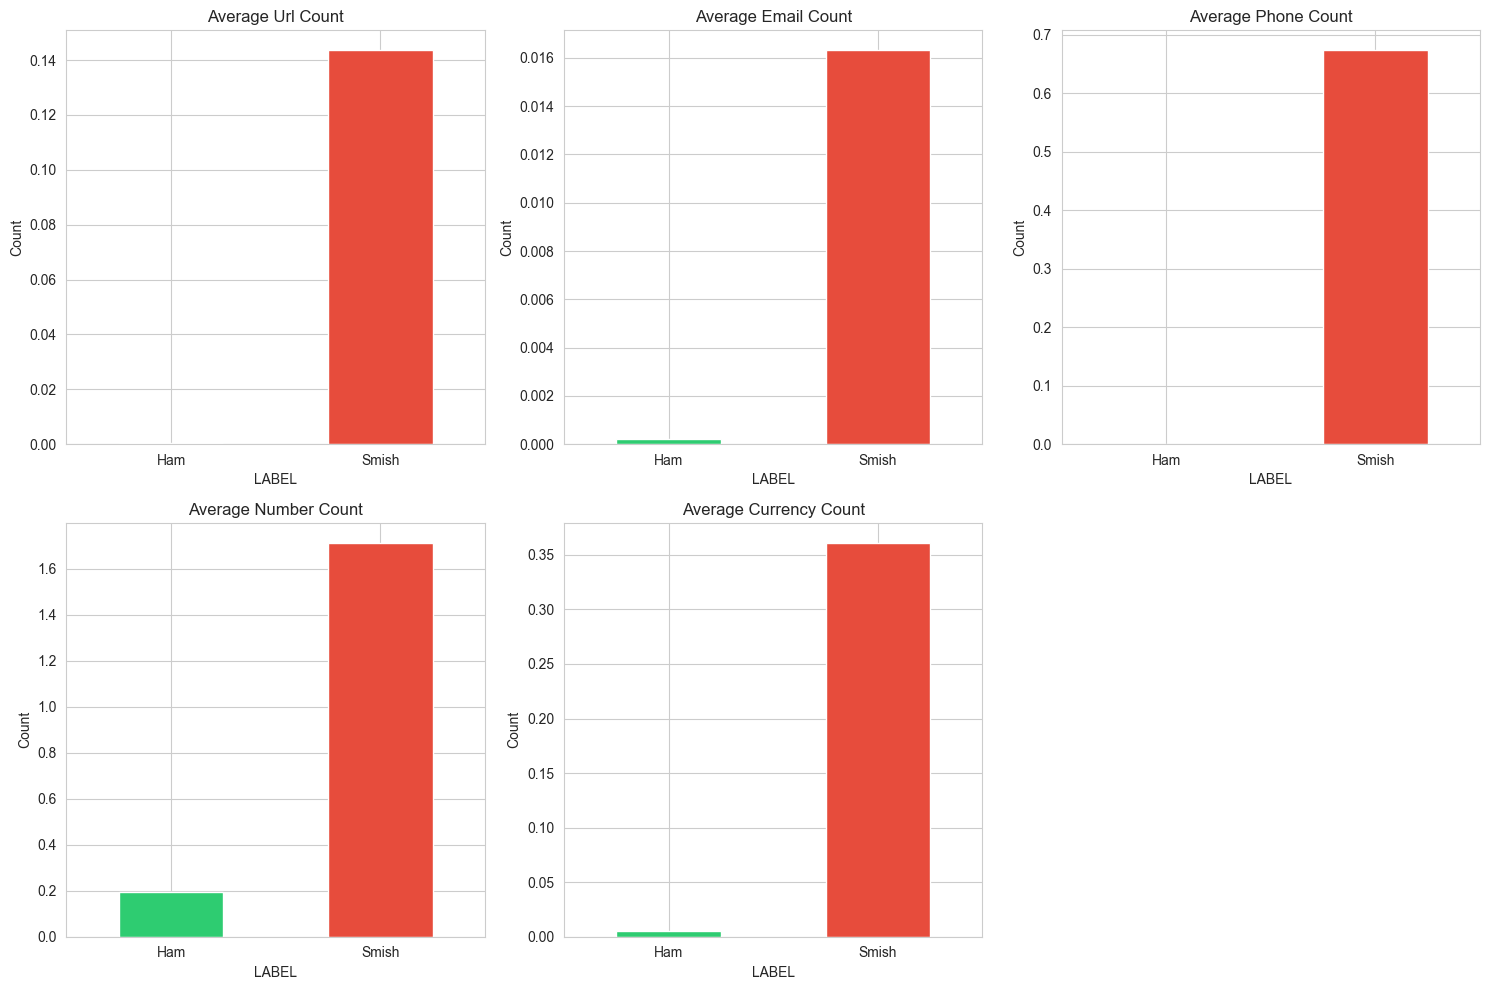

In [48]:
# Special token analysis
print("Average special token counts by class:")
token_features = ['url_count', 'email_count', 'phone_count', 'number_count', 'currency_count']
print(df.groupby('LABEL')[token_features].mean())

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(token_features):
    df.groupby('LABEL')[feature].mean().plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'Average {feature.replace("_", " ").title()}', fontsize=12)
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticklabels(['Ham', 'Smish'], rotation=0)

axes[-1].axis('off')
plt.tight_layout()
plt.show()


# Save All Preprocessed Data

In [49]:
# Save sequences (for text-only models like simple CNN, LSTM)
np.save('X_seq_train.npy', X_seq_train)
np.save('X_seq_test.npy', X_seq_test)
print("Saved: X_seq_train.npy, X_seq_test.npy")

# Save additional features (for hybrid models)
np.save('X_feat_train.npy', X_feat_train)
np.save('X_feat_test.npy', X_feat_test)
print("Saved: X_feat_train.npy, X_feat_test.npy")

# Save labels
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
print("Saved: y_train.npy, y_test.npy")




Saved: X_seq_train.npy, X_seq_test.npy
Saved: X_feat_train.npy, X_feat_test.npy
Saved: y_train.npy, y_test.npy
